Ce TP est inspiré d'idées présentées dans l'article **LOGICSEG: Parsing Visual Semantics with Neural Logic Learning and Reasoning**, de Liulei Li et al. paru en 2023.
.

Merci à Edgar Remy et Alice Dissoubray d'avoir constitué le dataset !


Nous nous intéressons dans ce TP à une application de reconnaissance d'espèces d'arthropodes dans des images. Plus précisément, nous allons essayer de reconnaître des espèces appartenant à la classe des collemboles (*Entognatha*). Voici à quoi ces petits arthropodes de quelques millimètres ressemblent :    

<center> <img src="https://drive.google.com/uc?id=1uZdfVGQb6Uo_PGOY-gdwKKRziKMAdAVe" width=200>
<img src="https://drive.google.com/uc?id=18AX5JBmBKxOpIu3_2SlHXAtOS1nc_LsG" width=200>
<img src="https://drive.google.com/uc?id=14fdPDb5DdsnKqgXSbqaiH0hk0RM8h1YF" width=200></center>
<caption><center> Quelques spécimens de collemboles </center></caption>

Notre base de données compte presque 80 espèces de collemboles (il en existe beaucoup plus), et les reconnaître est évidemment très compliqué.

Cependant, nous disposons d'une information supplémentaire sur ces espèces : nous connaissons leur répartition dans l'arbre taxonomique. Une classe est en effet divisée en ordres, familles, genres et espèces.

<center> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Taxonomic_hierarchy.svg/1024px-Taxonomic_hierarchy.svg.png" width=400></center>


Voici une représentation (circulaire, pour plus de concision) de l'arbre taxonomique sous-jacent à notre base de données :


<center> <img src="https://raw.githubusercontent.com/edgaremy/small-collomboles/refs/heads/main/static_visualization.png" width=600></center>

La classe *Entognatha* est donc constituée de 4 ordres (*Entomobryomorpha*, *Symphypleona*, *Poduromorpha*, *Neelipleona*), chacun constitué de familles, etc. A l'extérieur du cercle, on trouve les 79 espèces de notre base de données.


**L'objectif de ce TP est d'intégrer les informations de cet arbre taxonomique dans l'entraînement du modèle afin de gagner en robustesse.**


# Chargement et visualisation des données

Commençons par récupérer les données :

In [1]:
!git clone https://github.com/edgaremy/small-collomboles.git

Cloning into 'small-collomboles'...
remote: Enumerating objects: 6609, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6609 (delta 5), reused 3 (delta 0), pack-reused 6596 (from 3)
Receiving objects: 100% (6609/6609), 62.44 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (6391/6391), done.


Le bloc de code suivant nous permet d'éditer un histogramme pour visualiser le nombre d'images d'apprentissage pour chaque espèce de la base de données :

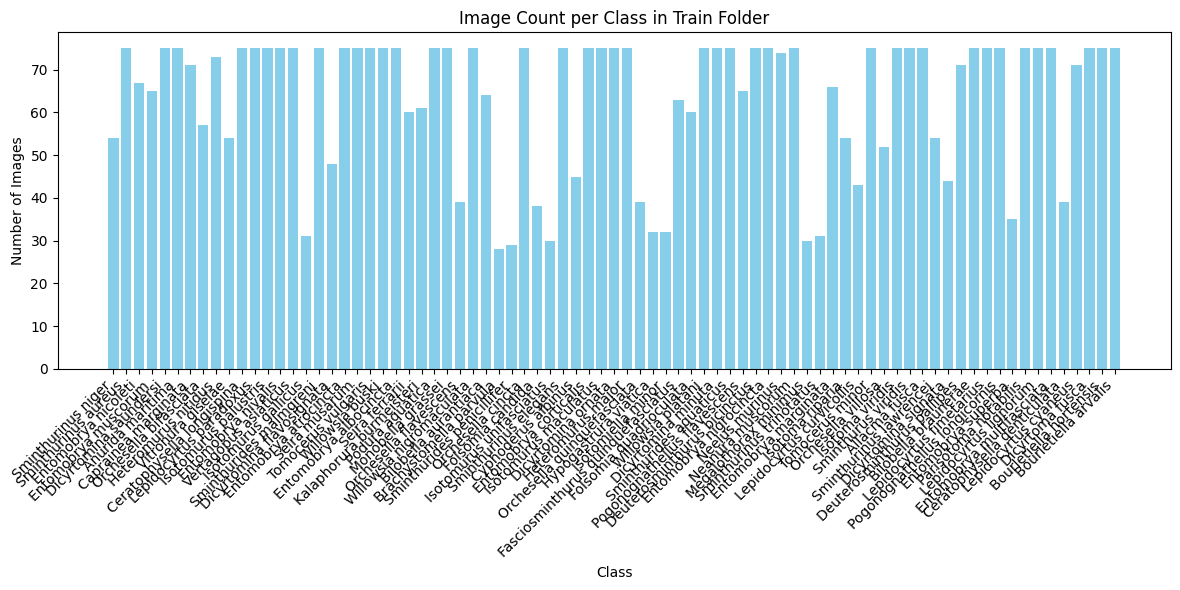

In [2]:
import os
import matplotlib.pyplot as plt

# Path to the train directory
train_dir = '/content/small-collomboles/dataset/train'

# Dictionary to store count of images per class
class_counts = {}

# Iterate through each class subfolder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])
        class_counts[class_name] = num_images

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Train Folder')
plt.tight_layout()
plt.show()

La base est un peu déséquilibrée, mais ce déséquilibre a été contrôlé en limitant le nombre d'images des classes majoritaires.

Pour la suite nous allons également limiter la taille des images à $128 \times 128$, afin de conserver des entraînements de durée raisonnable.

In [3]:
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)

# Présentation du problème et première version

Comme le problème de prédiction de l'espèce est difficile, il est possible que le modèle n'atteigne pas une confiance suffisante pour pouvoir être utilisé. Dans beaucoup d'applications, les biologistes et écologues n'ont pas nécessairement besoin d'une précision à l'espèce : la famille ou l'ordre sont déjà des informations très intéressantes.

On va donc résoudre un problème qui ne consiste pas seulement à prédire l'espcèe de l'individu, mais aussi son genre, sa famille et son ordre. On parle d'apprentissage multi-tâche (*multi-task learning*) lorsque l'on veut faire résoudre à un modèle plusieurs problèmes en même temps.

Pour réaliser cela, on va créer un réseau qui comptera 4 sorties : une pour prédire l'ordre, une pour la famille, une pour le genre, et une pour l'espèce.  



---




Pour commencer, nous allons récupérer les informations de l'arbre taxonomique dans le fichier hierarchy.csv fourni dans la base de données.

In [4]:
import csv

ordres = []
familles = []
genres = []
especes = []
data = {}

with open('/content/small-collomboles/hierarchy.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        espece = row['species']
        ordre = row['order']
        famille = row['family']
        genre = row['genus']

        if ordre not in ordres:
            ordres.append(ordre)
        if famille not in familles:
            familles.append(famille)
        if genre not in genres:
            genres.append(genre)
        if espece not in especes:
            especes.append(espece)

        data[espece] = {
            'order': ordre,
            'family': famille,
            'genus': genre,
            'species': espece
        }

Ces variables contiennent les noms des classes pour les 4 problèmes que nous allons résoudre :

In [5]:
print(str(len(ordres)) + ' ordres : ', ordres)
print(str(len(familles)) + ' familles : ', familles)
print(str(len(genres)) + ' genres : ', genres)
print(str(len(especes)) + ' especes : ', especes)

4 ordres :  ['Symphypleona', 'Poduromorpha', 'Entomobryomorpha', 'Neelipleona']
15 familles :  ['Sminthuridae', 'Neanuridae', 'Bourletiellidae', 'Brachystomellidae', 'Hypogastruridae', 'Cyphoderidae', 'Dicyrtomidae', 'Entomobryidae', 'Isotomidae', 'Onychiuridae', 'Neelidae', 'Poduridae', 'Tomoceridae', 'Sminthurididae', 'Katiannidae']
37 genres :  ['Allacma', 'Anurida', 'Bilobella', 'Bourletiella', 'Brachystomella', 'Caprainea', 'Ceratophysella', 'Cyphoderus', 'Deuterosminthurus', 'Dicyrtoma', 'Dicyrtomina', 'Entomobrya', 'Fasciosminthurus', 'Folsomia', 'Heteromurus', 'Hypogastrura', 'Isotoma', 'Isotomiella', 'Isotomurus', 'Kalaphorura', 'Lepidocyrtus', 'Megalothorax', 'Monobella', 'Neanura', 'Neelus', 'Orchesella', 'Parisotoma', 'Podura', 'Pogonognathellus', 'Seira', 'Sminthurides', 'Sminthurinus', 'Sminthurus', 'Tomocerus', 'Vertagopus', 'Vitronura', 'Willowsia']
79 especes :  ['Allacma fusca', 'Anurida maritima', 'Bilobella aurantiaca', 'Bilobella braunerae', 'Bourletiella arvalis',

Le dictionnaire ```data``` permet de connaître l'ordre, la famille et le genre associés à chaque espèce.

In [6]:
print(data)

{'Allacma fusca': {'order': 'Symphypleona', 'family': 'Sminthuridae', 'genus': 'Allacma', 'species': 'Allacma fusca'}, 'Anurida maritima': {'order': 'Poduromorpha', 'family': 'Neanuridae', 'genus': 'Anurida', 'species': 'Anurida maritima'}, 'Bilobella aurantiaca': {'order': 'Poduromorpha', 'family': 'Neanuridae', 'genus': 'Bilobella', 'species': 'Bilobella aurantiaca'}, 'Bilobella braunerae': {'order': 'Poduromorpha', 'family': 'Neanuridae', 'genus': 'Bilobella', 'species': 'Bilobella braunerae'}, 'Bourletiella arvalis': {'order': 'Symphypleona', 'family': 'Bourletiellidae', 'genus': 'Bourletiella', 'species': 'Bourletiella arvalis'}, 'Bourletiella hortensis': {'order': 'Symphypleona', 'family': 'Bourletiellidae', 'genus': 'Bourletiella', 'species': 'Bourletiella hortensis'}, 'Brachystomella parvula': {'order': 'Poduromorpha', 'family': 'Brachystomellidae', 'genus': 'Brachystomella', 'species': 'Brachystomella parvula'}, 'Caprainea marginata': {'order': 'Symphypleona', 'family': 'Smint

## Création du modèle

Pour créer le modèle, vous pouvez reprendre le code écrit lors du TP1 de cette année, quand nous avons travaillé sur la localisation d'objet dans une image au moyen d'une boîte englobante?. A l'époque, nous avions 3 sorties : une pour la présence, une pour la boîte englobante, une pour la classe.

Cette fois-ci, nous allons définir un réseau avec 4 sorties : une pour l'ordre, une pour la famille, une pour le genre et une pour l'espèce.

Pour l'architecture du réseau, nous allons implémenter une version simplifiée de VGG afin de conserver des temps d'apprentissage raisonnables.

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
### A COMPLETER
# Nombre de classes = total des positions dans le vecteur label
NUM_CLASSES = len(ordres) + len(familles) + len(genres) + len(especes)

input_img = Input(shape=INPUT_SHAPE)
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(96, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
prev_layer = Flatten()(pool4)

# Têtes
ordre_output = Dense(len(ordres), activation='softmax', name='ordre_output')(prev_layer)
famille_output = Dense(len(familles), activation='softmax', name='famille_output')(prev_layer)
genre_output = Dense(len(genres), activation='softmax', name='genre_output')(prev_layer)
espece_output = Dense(len(especes), activation='softmax', name='espece_output')(prev_layer)

model = Model(inputs=input_img, outputs=[ordre_output, famille_output, genre_output, espece_output])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 63,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 63, 63,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 31, 31,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 31, 31,    │     55,392 │ max_pooling2d_9[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 15, 15,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 15, 15,    │    110,720 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 7, 7, 128) │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ordre_output        │ (None, 4)         │     25,092 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ famille_output      │ (None, 15)        │     94,095 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_output        │ (None, 37)        │    232,101 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ espece_output       │ (None, 79)        │    495,567 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,032,359 (3.94 MB)

 Trainable params: 1,032,359 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

## Chargement des données

Le chargement des données est un peu délicat : à chaque image de la base, nous devons associer 4 labels différents : un pour l'ordre, un pour la famille, un pour le genre et un pour l'espèce.

Le code est fourni, vous n'avez rien à compléter.


In [19]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class HierarchicalDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size, image_size, data, ordres, familles, genres, especes):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.data = data  # dict : species_name -> {order, family, genus, species}
        self.ordres = ordres
        self.familles = familles
        self.genres = genres
        self.especes = especes

        self.image_paths = []
        self.labels = []

        # Collecte des chemins d'images et des espèces associées
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for fname in os.listdir(class_dir):
                    if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                        path = os.path.join(class_dir, fname)
                        self.image_paths.append(path)
                        self.labels.append(class_name)  # class_name = espèce

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        x_batch = []
        ordre_batch = []
        famille_batch = []
        genre_batch = []
        espece_batch = []

        for path, species_name in zip(batch_paths, batch_labels):
            # Chargement de l'image
            img = load_img(path, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0
            x_batch.append(img_array)

            # Création des vecteurs de labels
            info = self.data[species_name]

            ordre_vec = np.zeros(len(self.ordres))
            ordre_vec[self.ordres.index(info['order'])] = 1
            ordre_batch.append(ordre_vec)

            famille_vec = np.zeros(len(self.familles))
            famille_vec[self.familles.index(info['family'])] = 1
            famille_batch.append(famille_vec)

            genre_vec = np.zeros(len(self.genres))
            genre_vec[self.genres.index(info['genus'])] = 1
            genre_batch.append(genre_vec)

            espece_vec = np.zeros(len(self.especes))
            espece_vec[self.especes.index(info['species'])] = 1
            espece_batch.append(espece_vec)

        return (
            np.array(x_batch),
            {
                'ordre_output': np.array(ordre_batch),
                'famille_output': np.array(famille_batch),
                'genre_output': np.array(genre_batch),
                'espece_output': np.array(espece_batch)
            }
        )


On peut maintenant implémenter nos chargeurs de données : un pour chaque ensemble (apprentissage, validation, test).

In [20]:
train_generator = HierarchicalDataGenerator(
    root_dir='/content/small-collomboles/dataset/train',
    batch_size=32,
    image_size=IMAGE_SIZE,
    data=data,
    ordres=ordres,
    familles=familles,
    genres=genres,
    especes=especes
)

# Vérification d'un batch
x, y = train_generator[0]
print("x shape:", x.shape)
print("y:", y)  # (batch_size, total_labels)

x shape: (32, 128, 128, 3)
y: {'ordre_output': array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]]), 'famille_output': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [21]:
val_generator = HierarchicalDataGenerator(
    root_dir='/content/small-collomboles/dataset/val',
    batch_size=32,
    image_size=IMAGE_SIZE,
    data=data,
    ordres=ordres,
    familles=familles,
    genres=genres,
    especes=especes
)

In [22]:
test_generator = HierarchicalDataGenerator(
    root_dir='/content/small-collomboles/dataset/test',
    batch_size=32,
    image_size=IMAGE_SIZE,
    data=data,
    ordres=ordres,
    familles=familles,
    genres=genres,
    especes=especes
)

## Entraînement du modèle

On définit une fonction de perte et une métrique pour chaque sortie du réseau : ce seront toujours les mêmes (entropie croisée et accuracy).

In [25]:
from tensorflow.keras import optimizers
### A COMPLETER
adam = optimizers.Adam(learning_rate=0.0003)
model.compile(
    optimizer='adam',
    loss={
        'ordre_output': 'categorical_crossentropy',
        'famille_output': 'categorical_crossentropy',
        'genre_output': 'categorical_crossentropy',
        'espece_output': 'categorical_crossentropy'
    },
    metrics={
        'ordre_output': 'accuracy',
        'famille_output': 'accuracy',
        'genre_output': 'accuracy',
        'espece_output': 'accuracy'
    }
)

In [26]:
model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - espece_output_accuracy: 0.0134 - espece_output_loss: 4.5037 - famille_output_accuracy: 0.4412 - famille_output_loss: 2.0750 - genre_output_accuracy: 0.1105 - genre_output_loss: 3.2647 - loss: 10.9266 - ordre_output_accuracy: 0.5537 - ordre_output_loss: 1.0835 - val_espece_output_accuracy: 0.0293 - val_espece_output_loss: 4.2343 - val_famille_output_accuracy: 0.3821 - val_famille_output_loss: 2.2247 - val_genre_output_accuracy: 0.1347 - val_genre_output_loss: 3.2969 - val_loss: 10.8073 - val_ordre_output_accuracy: 0.5534 - val_ordre_output_loss: 1.0467
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - espece_output_accuracy: 0.0197 - espece_output_loss: 4.2747 - famille_output_accuracy: 0.3829 - famille_output_loss: 2.0611 - genre_output_accuracy: 0.1604 - genre_output_loss: 3.2137 - loss: 10.5792 - ordre_output_accuracy: 0.5614 - ordre_output_loss: 1.0295 - val_espece_output_accuracy: 0.0278 - val_espece_output_loss: 4.1723 -

Plusieurs points sont à noter :    

*   Le modèle sous-apprend clairement, ce qui n'est pas étonnant : il y a beaucoup de classes, les espèces se ressemblent et sont difficiles à distinguer même pour un humain. Nous avons gardé les images assez petites, ce qui signifie que certains détails importants manquent au modèle pour l'identification.
*   Mais, d'un autre côté, le modèle sur-apprend également ! Il est vrai que nous nous n'avons pas mis en place d'augmentation de données pour éviter de rendre le temps d'entraînement prohibitif.

Pour améliorer les résultats, il faudrait donc utiliser un réseau avec une plus grande capacité (par exemple, un ResNet-50), tout en régularisant l'apprentissage avec une forte augmentation de données. Un tel apprentissage prendrait quelques heures et n'est donc pas possible sur le temps du TP, mais donnerait de bien meilleurs résultats !

Pour la suite, nous allons nous contenter de cette baseline.


## Analyse des résultats

Pour affiner notre lecture des résultats, affichons des métriques plus détaillées sur l'ensemble de test pour chaque niveau taxonomique

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.activations import sigmoid
import numpy as np

def evaluate_multitask_model(model, test_generator):
    true_ordres, pred_ordres = [], []
    true_familles, pred_familles = [], []
    true_genres, pred_genres = [], []
    true_especes, pred_especes = [], []

    for i in range(test_generator.__len__()):
        x_batch, y_batch = test_generator.__getitem__(i)

        # Prédictions du modèle
        preds = model.predict(x_batch, verbose=0)

        if isinstance(preds, list):
            ordre_preds, famille_preds, genre_preds, espece_preds = preds
        else:
            ordre_preds = preds['ordre_output']
            famille_preds = preds['famille_output']
            genre_preds = preds['genre_output']
            espece_preds = preds['espece_output']

        # Vraies étiquettes (indices de la classe vraie)
        y_true_ordre = np.argmax(y_batch['ordre_output'], axis=1)
        y_true_famille = np.argmax(y_batch['famille_output'], axis=1)
        y_true_genre = np.argmax(y_batch['genre_output'], axis=1)
        y_true_espece = np.argmax(y_batch['espece_output'], axis=1)

        # Prédictions : sigmoid + argmax
        y_pred_ordre = np.argmax(ordre_preds, axis=1)
        y_pred_famille = np.argmax(famille_preds, axis=1)
        y_pred_genre = np.argmax(genre_preds, axis=1)
        y_pred_espece = np.argmax(espece_preds, axis=1)

        # Accumuler
        true_ordres.extend(y_true_ordre)
        pred_ordres.extend(y_pred_ordre)

        true_familles.extend(y_true_famille)
        pred_familles.extend(y_pred_famille)

        true_genres.extend(y_true_genre)
        pred_genres.extend(y_pred_genre)

        true_especes.extend(y_true_espece)
        pred_especes.extend(y_pred_espece)

    # Fonction pour afficher les métriques
    def print_metrics(y_true, y_pred, level_name):
        print(f"\n--- {level_name.upper()} ---")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
        print("Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
        print("F1 Score:", f1_score(y_true, y_pred, average='macro', zero_division=0))

    print_metrics(true_ordres, pred_ordres, "ordre")
    print_metrics(true_familles, pred_familles, "famille")
    print_metrics(true_genres, pred_genres, "genre")
    print_metrics(true_especes, pred_especes, "espece")

In [28]:
evaluate_multitask_model(model, test_generator)


--- ORDRE ---
Accuracy: 0.6228070175438597
Precision: 0.5077176120293209
Recall: 0.4812575152810715
F1 Score: 0.4923413617573999

--- FAMILLE ---
Accuracy: 0.3757309941520468
Precision: 0.2881302646817286
Recall: 0.2168372104043269
F1 Score: 0.23126743632182076

--- GENRE ---
Accuracy: 0.1871345029239766
Precision: 0.1980711348868871
Recall: 0.13591091361916297
F1 Score: 0.14580484190258458

--- ESPECE ---
Accuracy: 0.12426900584795321
Precision: 0.15966949716949713
Recall: 0.12924452481414506
F1 Score: 0.13148905144452872


On peut également calculer la sévérité des erreurs du modèle au niveau espèce, en cherchant (lorsque le modèle se trompe, c'est-à-dire la grande majorité du temps) le plus proche ancêtre commun entre espèce prédite est espèce réelle. Une sévérité de 0 signifie que la prédiction est correcte, une sévérité de 1 signifie que l'on s'est trompé d'espèce mais que le genre est correct, une sévérité de 2 signifie que la famille est correcte, etc.

In [33]:
### A COMPLETER
def hierarchical_severity(model, test_generator, taxo_info, especes):
    """
    Calcule la sévérité moyenne d’erreurs hiérarchiques.
    y_true, y_pred : matrices binaires (batch_size, nb_classes_especes)
    """
    severities = []

    true_indices, pred_indices = [], []

    for i in range(test_generator.__len__()):
        x_batch, y_batch = test_generator.__getitem__(i)

        # Prédictions du modèle
        preds = model.predict(x_batch, verbose=0)

        if isinstance(preds, list):
            _, _, _, espece_preds = preds
        else:
            espece_preds = preds['espece_output']

        # Vraies étiquettes (indices de la classe vraie)
        y_true_espece = np.argmax(y_batch['espece_output'], axis=1)

        # Prédictions
        y_pred_espece = np.argmax(espece_preds, axis=1)

        # Accumuler
        true_indices.extend(y_true_espece)
        pred_indices.extend(y_pred_espece)

    for true_idx, pred_idx in zip(true_indices, pred_indices):
        true_species = especes[true_idx]
        pred_species = especes[pred_idx]

        if true_species == pred_species:
            severity = 0
        else:
            true_info = taxo_info[true_species]
            pred_info = taxo_info[pred_species]

            if true_info['genus'] == pred_info['genus']:
                severity = 1
            elif true_info['family'] == pred_info['family']:
                severity = 2
            elif true_info['order'] == pred_info['order']:
                severity = 3
            else:
                severity = 4

        severities.append(severity)

    return np.mean(severities)


In [34]:
print(hierarchical_severity(model, test_generator, data, especes))

2.8084795321637426


# Implémentation d'une fonction de coût "logique"

Si nous analysions les prédictions du modèle précédent, nous pourrions voir qu'en plus de ne pas être bonnes, **elles ne sont pas cohérentes avec l'arbre taxonomique**. Par exemple, le modèle peut prédire une espèce et une famille alors que cette espèce n'appartient pas à cette famille.

Une idée pour résoudre ce problème est d'implémenter un terme dans la fonction de coût qui va essayer de **renforcer cette cohérence**. Pour cela, on peut formuler une règle logique qui impose que lorsqu'un noeud est prédit à un niveau hiérarchique donné, alors un des fils de ce noeud sera prédit au niveau hiérarchique inférieur. La figure ci-dessous illustre ce principe.

<center> <img src="https://drive.google.com/uc?id=15Ueo_hbZ3yz7wzjbRm1HnpOnMbMO7A-0" width=200>
<img src="https://drive.google.com/uc?id=1eAf7ZXoLDV9D0Vu3ku9A9OFNXeZMbgHU" width=360></center>


Cette formulation logique est intéressante, mais a priori incompatible avec l'entraînement des réseaux de neurones. Tout d'abord, les prédictions du réseau ne sont pas booléennes mais continues (entre 0 et 1). Discrétiser ces prédictions pour leur appliquer des règles logiques est une opération qui empêcherait le bon fonctionnement de la descente de gradient. Il est donc nécessaire de faire appel à la logique floue, qui permet de modéliser des règles booléennes dans un cadre probabiliste.


<center> <img src="https://drive.google.com/uc?id=1LuVbAP7BUN3tXQfAhTuugwJ4G2qt9TbG" width=400></center>

Ainsi, par exemple, pour des prédicats $A$ et $B$ ayant des probabilités $p_A$ et $p_B$ d'être vrais, la probabilité du prédicat $A * B$ ("et" logique) peut s'exprimer $p_{A*B} = p_A p_B$. De la même manière la probabilité du prédicat $A + B$ ("ou" logique) peut s'exprimer $p_{A+B} = \text{max}(p_A, p_B)$.

Pour un noeud $\nu$ qui n'est pas une feuille ($\nu ∉ N_1$), la règle logique que nous avons énoncée précédemment peut s'écrire :    
$$ \nu ⇒ c_{\nu}^1 \vee c_{\nu}^2 \vee ... \vee c_{\nu}^n  $$
où $n$ désigne ici le nombre de fils de $\nu$ et $c_{\nu}^i$ est le i-ème noeud fils de $\nu$.

Grâce aux formules énoncées précédemment on sait donc que la probabilité d'un tel prédicat s'exprime donc :
$$G(\nu) = 1 - s[\nu] + s[\nu]. \max_{1 \leq i \leq n} s[c_{\nu}^i]$$

où $s[x]$ désigne la probabilité prédite par le réseau pour le noeud $x$.

L'objectif est de maximiser la probabilité de ce prédicat, et donc de minimiser $\lnot G(\nu) = 1 - G(\nu)$ pour tous les noeuds de l'arbre taxonomique qui ne sont pas des feuilles. On veut donc minimiser la fonction de perte logique $L_D$ définie ainsi :     
$$ L_D = \frac{1}{|N|-|N_1|} \sum_{\nu \in |N| \setminus |N_1|} 1 - G(\nu)$$





## Matrice H

Pour implémenter cette fonction de coût, il est utile de construire une matrice qui résume les relations de l'arbre taxonomique.

Pour cela, on considère tous les noeuds de l'arbre taxonomique en partant de la racine jusqu'aux feuilles. Dans l'exemple ci-dessous, les noeuds sont rangés dans l'ordre a, b, c, d, e, f, g.


<center> <img src="https://drive.google.com/uc?id=10_vOBdKsWMS9_CDYj5YE-Y9w1XzrHTqh" width=400></center>

La première ligne de la matrice indique qui sont les noeuds fils de a : il s'agit des noeuds b et c : on positionne donc H(1,2) et H(1,3) à 1 et tous les autres coefficients à 0.
On procède de même pour les fils de b (d et e en 4e et 5e position), et c (f et g en 6e et 7e position). Les noeuds d, e, f et g sont des feuilles et n'ont aucun fils, les lignes correspondantes de la matrice H sont donc constituées de 0.

Le code ci-dessous implémente la construction de la matrice H à partir de la hiérarchie taxonomique des collemboles.

In [42]:
from collections import defaultdict

# Calcule l'offset pour chaque niveau
n_ordres = len(ordres)
n_familles = len(familles)
n_genres = len(genres)
n_especes = len(especes)

idx_ordres = {name: i for i, name in enumerate(ordres)}
idx_familles = {name: i + n_ordres for i, name in enumerate(familles)}
idx_genres = {name: i + n_ordres + n_familles for i, name in enumerate(genres)}
idx_especes = {name: i + n_ordres + n_familles + n_genres for i, name in enumerate(especes)}

# Fusion pour accès global
idx_all = {**idx_ordres, **idx_familles, **idx_genres, **idx_especes}


parent_to_children = defaultdict(set)

for sp_name, info in data.items():
    order = info['order']
    family = info['family']
    genus = info['genus']
    species = info['species']

    # Ajoute les relations dans le graphe
    parent_to_children[idx_ordres[order]].add(idx_familles[family])
    parent_to_children[idx_familles[family]].add(idx_genres[genus])
    parent_to_children[idx_genres[genus]].add(idx_especes[species])

# La structure de données parent_to_children permet de connaître la liste des noeuds fils de chaque noeud parent.
parent_to_children = {k: list(v) for k, v in parent_to_children.items()}


### A COMPLETER
def build_H_matrix(parent_to_children, total_nodes):
    H = np.zeros((total_nodes,total_nodes))
    for k in range(len(parent_to_children.keys())):
        fils = parent_to_children[k]
        for i in range(len(fils)):
            H[k][fils[i]] = 1
    return H


total_nodes = n_ordres + n_familles + n_genres + n_especes
H = build_H_matrix(parent_to_children, total_nodes)


## Implémentation de $L_D$.

Reprenons l'exemple de l'arbre simple dans la section précédente.

La loss $L_D$ s'exprime dans ce cas :

$$ L_D = \frac{1}{3} \left[ (s[a] - s[a] \max(s[b], s[c]) + (s[b] - s[b] \max(s[d], s[e]) + (s[c] - s[c] \max(s[f], s[g]) \right]$$

Pour écrire cette fonction de coût de manière efficace, il faut l'exprimer matriciellement.

Posons $s$ la prédiction du réseau :    
$$ s = [ s[a], s[b], s[c], s[d], s[e], s[f], s[g]]^T$$

Si nous calculons $ H * s^T$ (avec $*$ la multiplication terme à terme), nous obtenons :

$$ H * s^T = \begin{bmatrix}
0 & s[b] & s[c] & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & s[d] & s[e] & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & s[f] & s[g] \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}$$

et donc :

$$ \max(H * s^T, \text{axis}=1) = \begin{bmatrix}
\max(s[b], s[c])\\
\max(s[d], s[e])\\
\max(s[f], s[g])\\
0 \\
0 \\
0 \\
0
\end{bmatrix}$$

Enfin :

$$ s * \max(H * s^T, \text{axis}=1) = \begin{bmatrix}
s[a] \max(s[b], s[c])\\
s[b] \max(s[d], s[e])\\
s[c] \max(s[f], s[g])\\
0 \\
0 \\
0 \\
0
\end{bmatrix}$$


En outre :
$$ \max(H , \text{axis}=1) = \begin{bmatrix}
1\\
1\\
1\\
0 \\
0 \\
0 \\
0
\end{bmatrix}$$

Et donc :

$$ s * \max(H , \text{axis}=1) - s * \max(H * s^T, \text{axis}=1) = \begin{bmatrix}
s[a] - s[a] \max(s[b], s[c])\\
s[b] - s[b] \max(s[d], s[e])\\
s[c] - s[c] \max(s[f], s[g])\\
0 \\
0 \\
0 \\
0
\end{bmatrix}$$

En sommant ce vecteur on obtient la somme recherchée, qu'il faut diviser par 3, c'est-à-dire par le nombre de noeuds non feuilles. On peut par exemple l'obtenir en calculant la somme du vecteur $\max(H , \text{axis}=1)$.



Bon.

Ceci, c'est la version simple compréhensible par le commun des mortels. Malheureusement, les choses ne sont pas si simples car dans notre cas, la prédiction du réseau se fait **sur un batch de données**. Il y a donc une dimension supplémentaire à nos calculs.

La fonction de coût ci-dessous implémente les calculs détaillés précédemment. A vous de faire le lien entre les opérations détaillées ci-avant et les étapes implémentées. Si vous comprenez ce qui se passe, vous devriez pouvoir compléter la fin de la fonction de coût.

```terme1``` désigne la somme de $s * \max(H , \text{axis}=1)$ et ```terme2``` désigne la somme de $- s * \max(H * s^T, \text{axis}=1)$.

In [ ]:
import tensorflow as tf

class DRuleLoss(tf.keras.losses.Loss):
    def __init__(self, H_raw, name='drule_loss'):
        super().__init__(name=name)
        self.H = tf.convert_to_tensor(H_raw, dtype=tf.float32)  # shape: (N, N)

        one_tensor = tf.ones((self.H.shape[0], 1), dtype=tf.float32)
        sum_H = tf.reduce_sum(self.H, axis=1, keepdims=True)
        self.branches = tf.minimum(sum_H, one_tensor)  # shape: (N, 1)
        self.branch_count = tf.reduce_sum(self.branches)  # scalar

    def call(self, y_true, y_pred):
        # y_pred: shape (batch_size, N)
        batch_size = tf.shape(y_pred)[0]
        N = tf.shape(y_pred)[1]

        # Expand y_pred to shape [batch_size, N, N]
        S = tf.tile(tf.expand_dims(y_pred, axis=2), [1, 1, N])
        S_T = tf.transpose(S, perm=[0, 2, 1])  # (batch_size, N, N)

        H_batch = tf.tile(tf.expand_dims(self.H, axis=0), [batch_size, 1, 1])  # (batch_size, N, N)
        branches_T = tf.transpose(self.branches)  # (1, N)
        s_branch = branches_T * y_pred  # (batch_size, N)

        # max values over dimension 2 in (S_T * H_batch)
        max_values = tf.reduce_max(S_T * H_batch, axis=2)  # shape: (batch_size, N)

        # A COMPLETER
        terme1 = np.multiply(s_branch, np.max(H_batch, axis=2)) # (batch_size,)
        terme2 = np.multiply(-1*S, np.max(np.multiply(H_batch,S_T), axis=1)) # (batch_size,)
        loss_per_sample =  # (batch_size,)

        return tf.reduce_mean(loss_per_sample)  # scalar

In [ ]:
import numpy as np

H_raw = np.array([[0, 1.0, 1.0, 0, 0, 0, 0], [0, 0, 0, 1.0, 1.0, 0, 0], [0, 0, 0, 0, 0, 1.0, 1.0],
             [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

In [ ]:
y_true = tf.constant([
    [1.0, 1.0, 0.01, 1.0, 0.01, 0.01, 0.01],
    [1.0, 0.01, 1.0, 0.01, 0.01, 1.0, 0.01]
], dtype=tf.float32)

# Les prédictions ne respectent pas la règle logique
y_pred = tf.constant([
    [1.0, 1.0, 0.01, 0.001, 0.01, 0.01, 0.01],
    [1.0, 0.01, 1.0, 0.01, 0.01, 0.01, 0.01]
], dtype=tf.float32)

# Calcul de la perte
loss_fn = DRuleLoss(H_raw)
loss_value = loss_fn(y_true, y_pred)
print("DRuleLoss:", loss_value.numpy())

Vous devriez obtenir un résultat de $0.33$ !

In [ ]:


import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

class LogicCategoricalLoss(tf.keras.losses.Loss):
    def __init__(self, H, drule_weight=1.0, ce_weight=1.0, name='logic_categorical_loss'):
        super().__init__(name=name)
        self.drule_weight = drule_weight
        self.drule_loss = DRuleLoss(H)
        self.ce_weight = ce_weight
        self.crossentropy = CategoricalCrossentropy()
        self.H = tf.convert_to_tensor(H, dtype=tf.float32)
        self.branch_count = tf.reduce_sum(tf.minimum(tf.reduce_sum(H, axis=1), 1.0))

    def call(self, y_true, y_pred):

        # Il y a plein de problèmes de format, donc on s'assure que les entrées sont bien des listes.
        if isinstance(y_pred, (list, tuple)):
            y_pred_list = list(y_pred)
        else:
            raise ValueError("y_pred should be a list of output tensors")

        if isinstance(y_true, dict):
            y_true_list = [y_true['ordre_output'], y_true['famille_output'],
                          y_true['genre_output'], y_true['espece_output']]
        elif isinstance(y_true, (list, tuple)):
            y_true_list = list(y_true)
        else:
            raise ValueError("y_true should be a list or dict of output tensors")

        # On concatène les vérité terrains et les prédictions dans un seul et même vecteur regroupant tous les niveaux taxonomiques.
        y_true_concat = tf.concat(y_true_list, axis=1)
        y_pred_concat = tf.concat(y_pred, axis=1)  # Concatenate predictions for all levels


        # === CATEGORICAL CROSS-ENTROPY LOSS ===
        ce_loss = 0
        # Calcul de l'entropie croisée à chaque niveau de la hiérarchie
        for yt, yp in zip(y_true_list, y_pred_list):
          ce_loss += self.crossentropy(yt, yp)

        # Application de la règle logique implémentée précédemment
        drule_loss = self.drule_loss(y_true_concat, y_pred_concat)

        total_loss = self.ce_weight * ce_loss + self.drule_weight * drule_loss
        return total_loss

In [ ]:
from tensorflow.keras import layers, models

# Nombre de classes = total des positions dans le vecteur label
NUM_CLASSES = len(ordres) + len(familles) + len(genres) + len(especes)

from tensorflow.keras import layers, Model, Input

input_img = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# Têtes
ordre_output = layers.Dense(len(ordres), activation='softmax', name='ordre_output')(x)
famille_output = layers.Dense(len(familles), activation='softmax', name='famille_output')(x)
genre_output = layers.Dense(len(genres), activation='softmax', name='genre_output')(x)
espece_output = layers.Dense(len(especes), activation='softmax', name='espece_output')(x)

model = Model(inputs=input_img, outputs=[ordre_output, famille_output, genre_output, espece_output])
model.summary()


Pour entraîner le modèle, on est obligé d'écrire la boucle d'entraînement à la main... Ceci parce que l'on a créé une seule loss pour nos 4 sorties mais que keras nous force à définir 4 losses si l'on utilise la fonction ```fit``` classique.

In [ ]:
import tensorflow as tf

# Initialisations diverses
loss_fn = LogicCategoricalLoss(H, drule_weight=0.1, ce_weight=1.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
train_loss_tracker = tf.keras.metrics.Mean(name="train_loss")


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model(x, training=True)
        # Calcul de la perte
        loss = loss_fn(y, y_pred)
    # Backward pass
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss_tracker.update_state(loss)
    return loss

# Boucle d'apprentissage
def train_model(dataset, epochs=10):
    for epoch in range(epochs):
        train_loss_tracker.reset_state()
        # Parcours des batches
        for i in range(train_generator.__len__()):
            x_batch, y_batch = train_generator.__getitem__(i)
            loss = train_step(x_batch, y_batch)
        print(f"Epoch {epoch+1}, Loss: {train_loss_tracker.result().numpy():.4f}")

train_model(train_generator, epochs=40)


In [ ]:
evaluate_multitask_model(model, test_generator)

In [ ]:
print(hierarchical_severity(model, test_generator, data, especes))

Bravo vous avez réussi à terminer le TP ; malheureusement, pour obtenir de vrais résultats (qui montreraient l'intérêt de ce que nous avons fait) il faudrait :    


1.   Un dataset plus conséquent, et des images plus grosses
2.   Un meilleur réseau
3.   Deux autres règles logiques
4.   Beaucoup de temps...

